## Package and helper imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from simpletransformers.classification import ClassificationModel
import torch
import pickle
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
# from transformers import TrainingArguments, Trainer
# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import EarlyStoppingCallback

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Ensure huggingface connection for pretrained LLM download(s)

In [3]:
import requests
url = "https://huggingface.co/"
requests.get(url, verify=True)

<Response [200]>

## Ensure GPU available for acceleration

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11683619180439687873
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4163895296
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6552564773498948965
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Define text cleaning function

In [6]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))    

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    df.text=df.text.apply(lambda x: str(x).replace("X",""))
    df.text=df.text.apply(lambda x: str(x).replace("XX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXXXXX","")) # removes redactions

    stopword_dict= set(stopwords.words('english'))

    def sw_remover(arr):
        res=[]
        for i in arr:
            if i not in stopword_dict:
                res.append(i)
        return res

    # def digit_remover(arr):
    #     res=[]
    #     for i in arr:
    #         if i.isdigit()==False:
    #             res.append(i)
    #     return res

    def lemmatizer(arr):
        lem=nltk.stem.WordNetLemmatizer()
        res=[lem.lemmatize(i) for i in arr]
        return res

    def joiner(arr):
        if len(arr)==0:
            return ''
        elif len(arr)==1:
            return arr[0]
        else:
            return ' '.join(arr)
    
    df.text = df.text.apply(lambda x: re.sub(r'\[rnt]',"",x))
    df.text = df.text.apply(lambda x: x.lower())
    df.text = df.text.apply(lambda x: x.split())
    df.text = df.text.apply(sw_remover)
    df.text = df.text.apply(lemmatizer)
    df.text = df.text.apply(joiner)

    df['len'] = df['text'].apply(len)

    return df

## Import FEATURE-ENGINEERED training and validation data from EDA

In [7]:
df_train = pd.read_parquet('./input/dataframes/df_train_FE.parquet')
df_train.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [9]:
df_train.shape

(46764, 32)

In [10]:
list(df_train.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

In [11]:
df_val = pd.read_parquet('./input/dataframes/df_val_FE.parquet')
df_val.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,I bought a house in XXXX XXXX in XXXX. It was ...,1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0
1,XX/XX/XXXX my husband and I took an equity lin...,1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0
2,"Dear sir/madam, I want ESCALLATE to remove the...",1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0
3,I had XXXX Alliance One Accounts on my credit ...,1,0,0,0.077625,0,0,0.024449,0,0.017963,0,0,-1.000000,1,0,0.000998,1,0.022168,0,0,0.003707,0,0,1,0,0,0,0,1,0,0,0
4,Portfolio Recovery continues to contact me and...,1,0,0,0.052890,0,0,0.039775,0,0.023024,0,0,-1.000000,1,0,0.010692,0,0.031150,0,0,0.000356,0,1,1,0,0,0,0,0,0,1,0


In [12]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           14029 non-null  object 
 1   timely_response                        14029 non-null  int32  
 2   consumer_disputed?                     14029 non-null  int32  
 3   days_between_receipt_and_sent          14029 non-null  int64  
 4   sub_product_freq                       14029 non-null  float64
 5   sub_product_null_flag                  14029 non-null  int32  
 6   sub_product_low_flag                   14029 non-null  int32  
 7   issue_freq                             14029 non-null  float64
 8   issue_low_flag                         14029 non-null  int32  
 9   sub_issue_freq                         14029 non-null  float64
 10  sub_issue_null_flag                    14029 non-null  int32  
 11  su

In [13]:
df_val.shape

(14029, 32)

In [14]:
list(df_val.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded targets for training and validation data

In [15]:
# Training data targets
y_train = pd.read_parquet('./input/y_targets/y_train_LE.parquet')
y_train.head()

,label
0,6
1,0
2,2
3,4
4,1


In [16]:
product_train = y_train['label'].value_counts()
print(product_train)

4     12286
6     10443
3      8768
2      5550
0      3998
1      2575
10     1490
9       603
8       508
5       466
7        77
Name: label, dtype: int64


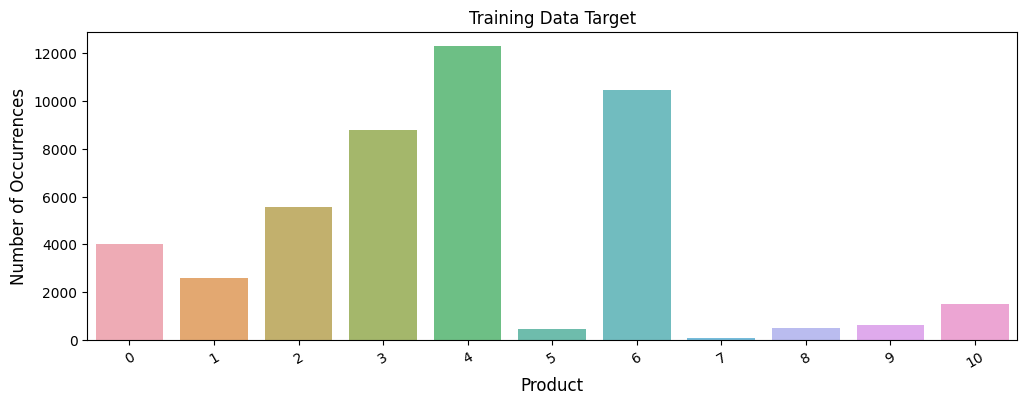

In [17]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_train.index, y=product_train.values, alpha=0.8)
plt.title('Training Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [18]:
# Validation data targets
y_val = pd.read_parquet('./input/y_targets/y_val_LE.parquet')
y_val.head()

,label
0,6
1,6
2,4
3,4
4,4


In [19]:
product_val = y_val['label'].value_counts()
print(product_val)

4     3686
6     3133
3     2630
2     1665
0     1199
1      772
10     447
9      181
8      153
5      140
7       23
Name: label, dtype: int64


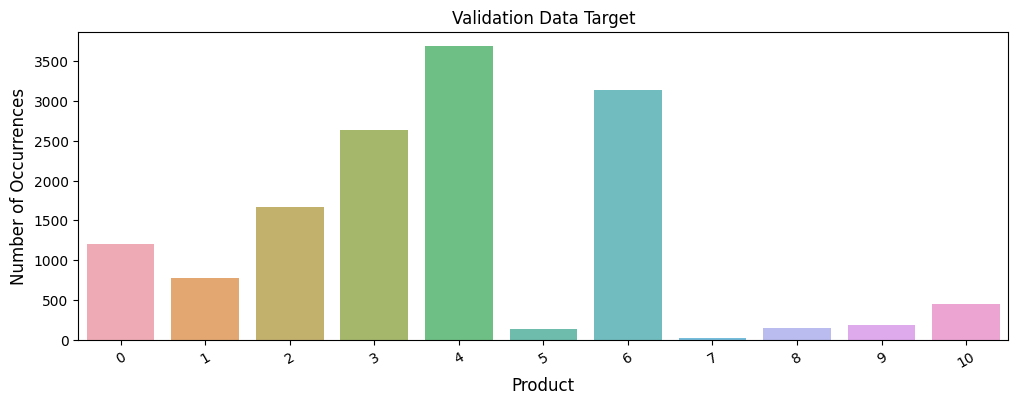

In [20]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_val.index, y=product_val.values, alpha=0.8)
plt.title('Validation Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [21]:
# Rename 'label' column to 'labels' so simpleTransformers can identify
y_train = y_train.rename({'label':'labels'},axis=1)
y_val = y_val.rename({'label':'labels'},axis=1)

In [22]:
# save prepped y_train df
y_train.to_parquet('./input/dataframes/transformers/y_train_labels.parquet')

In [23]:
# save prepped y_val df
y_val.to_parquet('./input/dataframes/transformers/y_val_labels.parquet')

## Inspect unvectorized text and ensure all is converted to string for both Training and Validation Data

In [24]:
for i in df_train['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

Dear Sir or Madam, Ever since XXXX XXXX XXXX sold our Mortgage Loan to XXXX, we have had nothing but problems. My husband and I back in 2009, tried to modify the loan. This was an absolute nightmare. After submitting information several times and going through numerous " scheduling '' of calls with Loan counselors, who when I finally got to talk to them, had nothing of substance to discuss or help me with and offered no guidance or help. They would tell me that I needed to get certain pieces of info. and schedule yet another call ( which were always 2 weeks later ) and take it from there, then it was like XXXX XXXX XXXX ... .. I would schedule call after call just to discuss separate pieces of my Loan Mod. Application. It made NO SENSE! I got nowhere and gave up. I have a file 3 inches thick with my application, with forms and notes and all the back up info that I scanned to them, which they claimed to never have received ... .. I finally gave up. With my husband laid off due the const

In [25]:
df_train = df_train.rename({'consumer_complaint_narrative':'text'},axis=1)

In [26]:
df_train['text'] = df_train['text'].astype(str)

In [27]:
for i in df_val['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

I bought a house in XXXX XXXX in XXXX. It was my primary residence. I fixed it up and made the payments regularly until about XXXX XXXX at which point I called the bank to see what options were available. I explained that I was unable to make the payments any longer, that my parents were sick and that I had put the house on the market in XXXX and moved to XXXX. I gave them all the information they requested. Since then they have continually bounced me from one representative to another almost like a shell game. They did this until the information was outdated and I had to submit all new information such as my XXXX tax statements, bank statements, recent pay stubs, and an explanation why I was unable to make the payments. They would then tell me via mail that I do n't meet investor guidelines. I talked to HUD and they tell me I do! The bank assigns me another representative and we go through the whole procedure again. By now we are 9 months into this process doing this hide and seek and

In [28]:
df_val = df_val.rename({'consumer_complaint_narrative':'text'},axis=1)

In [29]:
df_val['text'] = df_val['text'].astype(str)

## Join feature-engineered text and target dataframes for transformer

In [30]:
df_train = df_train.join(y_train)

In [31]:
df_val = df_val.join(y_val)

## Sanitize text

In [32]:
df_train = clean_text(df_train)

In [33]:
for i in df_train['text'].head(5):
    print(i)
    print("#####################")

dear sir madam ever since sold mortgage loan nothing problem husband back tried modify loan absolute nightmare submitting information several time going numerous scheduling '' call loan counselor finally got talk nothing substance discus help offered guidance help would tell needed get certain piece info schedule yet another call ( always week later ) take like would schedule call call discus separate piece loan mod application made sense got nowhere gave file inch thick application form note back info scanned claimed never received finally gave husband laid due construction industry slow time decided file bankruptcy believe given chance modify could avoided filing chapter year later loan sold nationstar issue stem bankruptcy attorney help get simple answer escrow sudden went per month tax go thing switch homeowner insurer payment gone around month le sent copy escrow analysis page raised payment upwards per month offer clear reason called given explanation matter fact told supposed se

In [34]:
df_val = clean_text(df_val)

In [35]:
for i in df_val['text'].head(5):
    print(i)
    print("#####################")

bought house primary residence fixed made payment regularly point called bank see option available explained unable make payment longer parent sick put house market moved gave information requested since continually bounced one representative another almost like shell game information outdated submit new information tax statement bank statement recent pay stub explanation unable make payment would tell via mail n't meet investor guideline talked hud tell bank assigns another representative go whole procedure month process hide seek start new year must submit tax bank info explaination cant make payment realtor going think least time past year realtor tell week going last time today get letter bank stating mortgage transferred another servicer going year month
#####################
husband took equity line credit bank america pre existing nd mortgage st mortgage ( ) time appraisal came bank america gave u new nd mortgage know could finance equity home still mortgage appraisal paying int

## Tokenize text

In [36]:
df_train['text'] = df_train.apply(
    lambda x: nltk.word_tokenize(x['text']), axis=1)

In [37]:
for i in df_train['text'].head(5):
    print(i)
    print("#####################")

['dear', 'sir', 'madam', 'ever', 'since', 'sold', 'mortgage', 'loan', 'nothing', 'problem', 'husband', 'back', 'tried', 'modify', 'loan', 'absolute', 'nightmare', 'submitting', 'information', 'several', 'time', 'going', 'numerous', 'scheduling', '``', 'call', 'loan', 'counselor', 'finally', 'got', 'talk', 'nothing', 'substance', 'discus', 'help', 'offered', 'guidance', 'help', 'would', 'tell', 'needed', 'get', 'certain', 'piece', 'info', 'schedule', 'yet', 'another', 'call', '(', 'always', 'week', 'later', ')', 'take', 'like', 'would', 'schedule', 'call', 'call', 'discus', 'separate', 'piece', 'loan', 'mod', 'application', 'made', 'sense', 'got', 'nowhere', 'gave', 'file', 'inch', 'thick', 'application', 'form', 'note', 'back', 'info', 'scanned', 'claimed', 'never', 'received', 'finally', 'gave', 'husband', 'laid', 'due', 'construction', 'industry', 'slow', 'time', 'decided', 'file', 'bankruptcy', 'believe', 'given', 'chance', 'modify', 'could', 'avoided', 'filing', 'chapter', 'year', 

In [38]:
df_val['text'] = df_val.apply(
    lambda x: nltk.word_tokenize(x['text']), axis=1)

In [39]:
for i in df_val['text'].head(5):
    print(i)
    print("#####################")

['bought', 'house', 'primary', 'residence', 'fixed', 'made', 'payment', 'regularly', 'point', 'called', 'bank', 'see', 'option', 'available', 'explained', 'unable', 'make', 'payment', 'longer', 'parent', 'sick', 'put', 'house', 'market', 'moved', 'gave', 'information', 'requested', 'since', 'continually', 'bounced', 'one', 'representative', 'another', 'almost', 'like', 'shell', 'game', 'information', 'outdated', 'submit', 'new', 'information', 'tax', 'statement', 'bank', 'statement', 'recent', 'pay', 'stub', 'explanation', 'unable', 'make', 'payment', 'would', 'tell', 'via', 'mail', "n't", 'meet', 'investor', 'guideline', 'talked', 'hud', 'tell', 'bank', 'assigns', 'another', 'representative', 'go', 'whole', 'procedure', 'month', 'process', 'hide', 'seek', 'start', 'new', 'year', 'must', 'submit', 'tax', 'bank', 'info', 'explaination', 'cant', 'make', 'payment', 'realtor', 'going', 'think', 'least', 'time', 'past', 'year', 'realtor', 'tell', 'week', 'going', 'last', 'time', 'today', 'g

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   text                                   46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [41]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   text                                   14029 non-null  object 
 1   timely_response                        14029 non-null  int32  
 2   consumer_disputed?                     14029 non-null  int32  
 3   days_between_receipt_and_sent          14029 non-null  int64  
 4   sub_product_freq                       14029 non-null  float64
 5   sub_product_null_flag                  14029 non-null  int32  
 6   sub_product_low_flag                   14029 non-null  int32  
 7   issue_freq                             14029 non-null  float64
 8   issue_low_flag                         14029 non-null  int32  
 9   sub_issue_freq                         14029 non-null  float64
 10  sub_issue_null_flag                    14029 non-null  int32  
 11  su

In [42]:
# save prepped df_train dataframe
df_train.to_parquet('./input/dataframes/transformers/df_y_train_tokenized.parquet')

In [44]:
# save prepped df_val dataframe
df_val.to_parquet('./input/dataframes/transformers/df_y_val_tokenized.parquet')

## Enable GPU acceleration

In [45]:
cuda_available = torch.cuda.is_available()

## BERT base uncased model

In [75]:
model_args = {"num_train_epochs": 1,
              "fp16": True, 
              "n_gpu": 1,
              "learning_rate": 4e-5,
              "train_batch_size": 32,
               "weight_decay": 1e-3, #"reprocess_input_data": True,
              "overwrite_output_dir": True,
              "no_cache":True, 
              "no_save":True,
              "save_eval_checkpoints":False,
              "save_model_every_epoch":False,
              "save_optimizer_and_scheduler":False,
              "use_early_stopping":True}

In [76]:
# Create a ClassificationModel with modified attributes and GPU acceleration (use_cuda=True)
model = ClassificationModel(
    'bert', 
    'bert-base-uncased', 
    num_labels=11, 
    args=model_args,
    use_cuda=cuda_available, #is_cuda_gpu_available,
    cuda_device=1
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [77]:
# Train the model
model.train_model(df_train)

  0%|          | 0/46764 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2923 [00:00<?, ?it/s]

## Assess model Accuracy and F1 Score on Validation data

In [ ]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='weighted')

In [ ]:
# Evaluate the model on Validation dataset
result, model_outputs, wrong_predictions = model.eval_model(df_val, acc=accuracy_score, f1=f1_multiclass)

  0%|          | 0/14029 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1754 [00:00<?, ?it/s]

In [ ]:
print(result)

{'mcc': 0.8102805100074923, 'acc': 0.8448214413001639, 'f1': 0.8425415274276015, 'eval_loss': 0.528297142183542}


In [ ]:
print(model_outputs)

[[ 0.96155506 -0.15471375 -0.40629286 ... -2.22780252 -2.21353269
  -1.64585412]
 [ 1.37362385 -0.19850746 -0.51009369 ... -2.26011133 -2.27221441
  -1.55057919]
 [-1.12098408 -0.03287375  0.98449969 ... -2.04535389 -2.94812393
  -1.57522452]
 ...
 [-0.8311221  -0.44779235 -0.2140888  ... -1.88468564 -1.6095047
  -1.68618941]
 [ 5.88516283 -0.47483876  1.10770965 ... -1.61313045 -0.92738819
  -1.89347827]
 [ 2.74324656 -2.07674766  1.96322322 ... -1.773911    5.38644838
  -2.29855132]]


- ### Pretrained bert-base-uncased LLM (12-layer, 768-hidden, 12-heads, 110M parameters) with 1 training epoch for simpleTransformers multi-classification with GPU acceleration performs fairly well with Accuracy and F1 score of ~84% and Mathew's Correlation Coefficient of ~81% on the validation dataset.
    - #### Evaluate performance on test dataset next.

## Load the test data for model evaluation on out-of-sample data

In [53]:
df_test = pd.read_parquet('./input/dataframes/df_test_FE.parquet')
df_test.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,My husband and I agreed to pay off our mortgag...,1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0
1,I am filing a complaint because EQUIFAX has ig...,1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0
2,This account is fraudulent and the company ref...,1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0
3,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",1,0,3,0.056710,0,0,0.012972,0,-1.000000,1,0,0.293032,0,0,0.004823,1,0.002994,0,1,0.000499,0,1,0,0,1,0,0,1,0,0,0
4,This company calls multiple times a day despit...,1,0,0,0.059538,0,0,0.043240,0,0.023283,0,0,-1.000000,1,0,0.009147,1,0.032762,0,0,0.002661,0,0,1,0,0,0,0,0,0,1,0


In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           6013 non-null   object 
 1   timely_response                        6013 non-null   int32  
 2   consumer_disputed?                     6013 non-null   int32  
 3   days_between_receipt_and_sent          6013 non-null   int64  
 4   sub_product_freq                       6013 non-null   float64
 5   sub_product_null_flag                  6013 non-null   int32  
 6   sub_product_low_flag                   6013 non-null   int32  
 7   issue_freq                             6013 non-null   float64
 8   issue_low_flag                         6013 non-null   int32  
 9   sub_issue_freq                         6013 non-null   float64
 10  sub_issue_null_flag                    6013 non-null   int32  
 11  sub_

In [55]:
df_test.shape

(6013, 32)

In [56]:
list(df_test.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded target for test data

In [57]:
# Test data targets
y_test = pd.read_parquet('./input/y_targets/y_test_LE.parquet')
y_test.head()

,label
0,6
1,3
2,4
3,0
4,4


In [58]:
product_test = y_test['label'].value_counts()
print(product_test)

4     1580
6     1343
3     1128
2      714
0      514
1      331
10     191
9       77
8       65
5       60
7       10
Name: label, dtype: int64


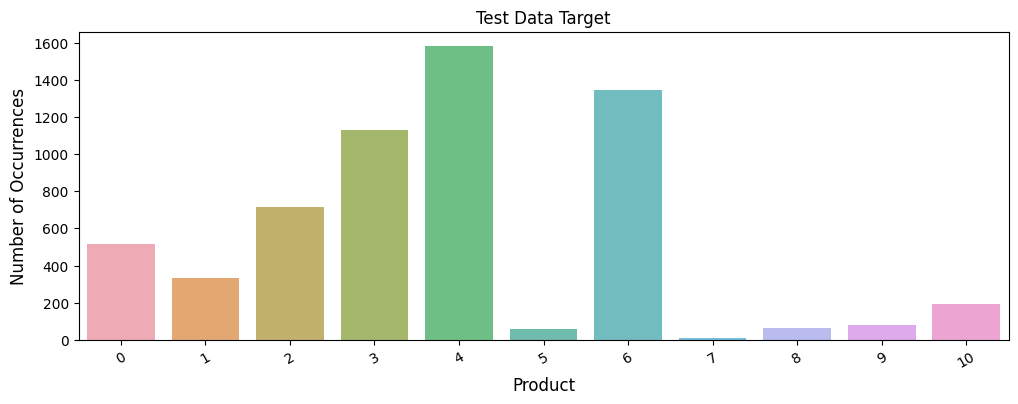

In [59]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_test.index, y=product_test.values, alpha=0.8)
plt.title('Test Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [60]:
# Rename 'label' column to 'labels' so simpleTransformers can identify
y_test = y_test.rename({'label':'labels'},axis=1)

In [61]:
# save prepped y_test df
y_test.to_parquet('./input/dataframes/transformers/y_test_labels.parquet')

## Inspect unvectorized text and ensure all is converted to string for Test Data

In [62]:
for i in df_test['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

My husband and I agreed to pay off our mortgage. We felt the best way to pay this off would be to start making a payment per day. Our payment amount is less than {$600.00}. We decided to pay {$600.00} each day until the mortgage was completely payed off. Understanding that we confirmed with the bank that each payment would be recognized as a monthly payment. And we would not be held responsible for payments in arrears, should either of us fall ill and not be able to make a payment during a 90 day period that would let us rest at ease that payments represented a monthly payment. We see a full months amount of interest taken out of the payment, even though we have made the payments on a daily basis. or even several payments on one day. A mortgage should be interest calculated on the days required between payments against the balance. May we please have this in writing as to why they are making this payment as principal and interest for the full month 's interest? Am I mistaken on this is

In [63]:
df_test = df_test.rename({'consumer_complaint_narrative':'text'},axis=1)

In [64]:
df_test['text'] = df_test['text'].astype(str)

## Join feature-engineered text and target dataframes for transformer

In [65]:
df_test = df_test.join(y_test)

## Sanitize text

In [66]:
df_test = clean_text(df_test)

In [67]:
for i in df_test['text'].head(5):
    print(i)
    print("#####################")

husband agreed pay mortgage felt best way pay would start making payment per day payment amount le decided pay day mortgage completely payed understanding confirmed bank payment would recognized monthly payment would held responsible payment arrears either u fall ill able make payment day period would let u rest ease payment represented monthly payment see full month amount interest taken payment even though made payment daily basis even several payment one day mortgage interest calculated day required payment balance may please writing making payment principal interest full month 's interest mistaken issue tell would problem escrow case could pay separately interest need corrected thought thank time consideration matter included documentation show application payment balance mortgage mortgage department helpful situation seems longer use regular method calculating interest given away automation calculated computer longer application master trifle ordinary statement sent soon make paym

## Tokenize text

In [68]:
df_test['text'] = df_test.apply(
    lambda x: nltk.word_tokenize(x['text']), axis=1)

In [69]:
for i in df_test['text'].head(5):
    print(i)
    print("#####################")

['husband', 'agreed', 'pay', 'mortgage', 'felt', 'best', 'way', 'pay', 'would', 'start', 'making', 'payment', 'per', 'day', 'payment', 'amount', 'le', 'decided', 'pay', 'day', 'mortgage', 'completely', 'payed', 'understanding', 'confirmed', 'bank', 'payment', 'would', 'recognized', 'monthly', 'payment', 'would', 'held', 'responsible', 'payment', 'arrears', 'either', 'u', 'fall', 'ill', 'able', 'make', 'payment', 'day', 'period', 'would', 'let', 'u', 'rest', 'ease', 'payment', 'represented', 'monthly', 'payment', 'see', 'full', 'month', 'amount', 'interest', 'taken', 'payment', 'even', 'though', 'made', 'payment', 'daily', 'basis', 'even', 'several', 'payment', 'one', 'day', 'mortgage', 'interest', 'calculated', 'day', 'required', 'payment', 'balance', 'may', 'please', 'writing', 'making', 'payment', 'principal', 'interest', 'full', 'month', "'s", 'interest', 'mistaken', 'issue', 'tell', 'would', 'problem', 'escrow', 'case', 'could', 'pay', 'separately', 'interest', 'need', 'corrected',

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   text                                   6013 non-null   object 
 1   timely_response                        6013 non-null   int32  
 2   consumer_disputed?                     6013 non-null   int32  
 3   days_between_receipt_and_sent          6013 non-null   int64  
 4   sub_product_freq                       6013 non-null   float64
 5   sub_product_null_flag                  6013 non-null   int32  
 6   sub_product_low_flag                   6013 non-null   int32  
 7   issue_freq                             6013 non-null   float64
 8   issue_low_flag                         6013 non-null   int32  
 9   sub_issue_freq                         6013 non-null   float64
 10  sub_issue_null_flag                    6013 non-null   int32  
 11  sub_

In [71]:
# save prepped df_test dataframe
df_test.to_parquet('./input/dataframes/transformers/df_y_test_tokenized.parquet')

## Assess model Accuracy and F1 Score on Test data

In [72]:
# Evaluate the model on Test dataset
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(df_test, acc=accuracy_score, f1=f1_multiclass)

  0%|          | 0/6013 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/752 [00:00<?, ?it/s]

In [73]:
print(result_test)

{'mcc': 0.814542523031679, 'acc': 0.8483286213204723, 'f1': 0.8456833693214488, 'eval_loss': 0.5280188761708485}


In [74]:
print(model_outputs_test)

[[ 0.61465776 -0.3285833  -1.06643903 ... -2.22561836 -2.25424695
  -1.45495725]
 [-1.19698656 -0.49420178 -0.81689137 ... -1.48504472 -1.52047181
  -1.20198703]
 [-0.5997569  -0.42783108  0.89182848 ... -1.63881183 -2.55891848
  -1.81029046]
 ...
 [-1.52295017  0.7562924  -0.17994785 ... -0.174768   -2.87623
  -0.64222938]
 [-1.38447022 -0.1229734   0.54148972 ... -1.50250316 -3.20864415
  -1.5010159 ]
 [ 0.67167962 -0.38985011 -1.03083205 ... -2.26355815 -2.1627717
  -1.44791961]]


- ### The model performed very similarly on the test dataset as the validation dataset with Accuracy and F1 score of ~85% and Mathew's Correlation Coefficient of ~81% on the test dataset.

## BERT Large uncased

In [7]:
# load tokenized training dataframe
df_train = pd.read_parquet('./input/dataframes/transformers/df_y_train_tokenized.parquet')

In [8]:
df_train.head(3)

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response,labels,len
0,"[dear, sir, madam, ever, since, sold, mortgage...",1,0,0,0.098495,0,0,0.097832,0,-1.0,1,0,-1.0,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0,6,1735
1,"[ach, transaction, withdrawal, account, withou...",1,0,0,0.019973,0,0,0.020742,0,-1.0,1,0,-1.0,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0,0,878
2,"[wife, received, paper, bill, chase, card, ser...",1,0,0,-1.000000,1,0,0.018283,0,-1.0,1,0,-1.0,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0,2,163


In [9]:
# load tokenized validation dataframe
df_val = pd.read_parquet('./input/dataframes/transformers/df_y_val_tokenized.parquet')

In [10]:
df_val.head(3)

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response,labels,len
0,"[bought, house, primary, residence, fixed, mad...",1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0,6,769
1,"[husband, took, equity, line, credit, bank, am...",1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0,6,1235
2,"[dear, sirmadam, want, escallate, remove, nega...",1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0,4,139


In [11]:
cuda_available = torch.cuda.is_available()

In [15]:
# Create a ClassificationModel with modified attributes and GPU acceleration (use_cuda=True)
model = ClassificationModel(
    'bert', 
    'bert-large-uncased', 
    num_labels=11, 
    args={"num_train_epochs": 1, "fp16": True, "n_gpu": 1, "learning_rate": 4e-5, "overwrite_output_dir": True}, #"reprocess_input_data": True, " 
    use_cuda=cuda_available, #is_cuda_gpu_available,
    cuda_device=1
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [16]:
# Train the model
model.train_model(df_train)

  0%|          | 0/46764 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/5846 [00:00<?, ?it/s]

(5846, 0.6798972107706291)

## Assess model Accuracy and F1 Score on Validation data

In [17]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='weighted')

In [18]:
# Evaluate the model on Validation dataset
result, model_outputs, wrong_predictions = model.eval_model(df_val, acc=accuracy_score, f1=f1_multiclass)

  0%|          | 0/14029 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1754 [00:00<?, ?it/s]

In [19]:
print(result)

{'mcc': 0.8244022865864482, 'acc': 0.8564402309501746, 'f1': 0.8541679441777809, 'eval_loss': 0.4896781569638288}


In [20]:
print(model_outputs)

[[ 1.77979326  0.46817097  0.32381961 ... -2.7097981  -3.43765163
  -1.25056279]
 [ 1.26641309 -0.115224   -0.94947231 ... -2.79276156 -3.83917379
  -1.20241618]
 [-0.81283849  0.02800251  1.79577613 ... -1.81015253 -3.15479946
  -1.52776122]
 ...
 [-0.53108609 -0.32950237  0.42721787 ... -2.5257926  -2.40311933
  -0.87345475]
 [ 6.41187668 -0.26876014  1.23721325 ... -2.41010284 -1.50895667
  -2.24304533]
 [ 3.45721483 -1.5082773   3.09394956 ... -2.2389102   5.13824654
  -2.1130197 ]]


- ### Pretrained bert-large-uncased LLM (24-layer, 1024-hidden, 16-heads, 340M parameters) with 1 training epoch for simpleTransformers multi-classification with GPU acceleration performs only slightly better than the bert-base-uncased LLM with F1 score and Accuracy of ~85/86% and Mathew's Correlation Coefficient of ~82% on the validation dataset.
    - #### Evaluate performance on test dataset next.

## Load the test data for model evaluation on out-of-sample data

In [21]:
# load tokenized test dataframe
df_test = pd.read_parquet('./input/dataframes/transformers/df_y_test_tokenized.parquet')

In [22]:
df_test.head(3)

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response,labels,len
0,"[husband, agreed, pay, mortgage, felt, best, w...",1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0,6,1826
1,"[filing, complaint, equifa, ignored, request, ...",1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0,3,253
2,"[account, fraudulent, company, refuse, remove,...",1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0,4,98


In [24]:
# Evaluate the model on Test dataset
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(df_test, acc=accuracy_score, f1=f1_multiclass)

  0%|          | 0/6013 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/752 [00:00<?, ?it/s]

In [25]:
print(result_test)

{'mcc': 0.8251322679767202, 'acc': 0.8571428571428571, 'f1': 0.8539173738158243, 'eval_loss': 0.4875485729005069}


In [26]:
print(model_outputs_test)

[[ 0.07288639  0.07712284 -1.13970864 ... -1.59373367 -3.88249016
  -0.62689865]
 [-1.03401554 -0.74709749  0.13950717 ... -2.60264611 -2.30399847
  -0.59721136]
 [-1.01924169  0.51335251  1.59316671 ... -0.99861568 -3.17220736
  -1.34367681]
 ...
 [-1.72565985  1.34124923  0.35642153 ...  0.60298139 -3.41338968
  -0.39880502]
 [-1.51029742  0.43059582  1.24585831 ... -0.97058797 -3.36513233
  -1.17122602]
 [ 0.43345636 -0.41482311 -1.71174765 ... -2.47501159 -3.54775572
  -0.66805679]]


- ### The model performed very similarly on the test dataset as the validation dataset with F1 score and Accuracy of ~85/86% and a Mathew's Correlation Coefficient of ~83% on the test dataset.

## Next Steps:
- ### Further evaluations are warranted, perhaps with additional text preprocessing, more training epochs, hyperparameter tuning (e.g. different learning rates), and different/larger pretrained LLMs.

### Appendix